In [ ]:
import pandas as pd
import numpy as np
import sqlite3
from pprint import pprint
import folium
from folium import plugins
from folium.plugins import HeatMap
%matplotlib inline
import matplotlib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import sklearn.ensemble as ske
import pygeohash as pgh
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
conn = sqlite3.connect("FPA_FOD_20170508.sqlite")

In [3]:
df = pd.read_sql_query("SELECT DISCOVERY_DOY,FIRE_YEAR,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE FROM 'Fires'", conn)
print(df.head()) #check the data

   DISCOVERY_DOY  FIRE_YEAR  STAT_CAUSE_CODE STAT_CAUSE_DESCR   LATITUDE  \
0             33       2005              9.0    Miscellaneous  40.036944   
1            133       2004              1.0        Lightning  38.933056   
2            152       2004              5.0   Debris Burning  38.984167   
3            180       2004              1.0        Lightning  38.559167   
4            180       2004              1.0        Lightning  38.559167   

    LONGITUDE STATE  DISCOVERY_DATE  FIRE_SIZE  
0 -121.005833    CA       2453403.5       0.10  
1 -120.404444    CA       2453137.5       0.25  
2 -120.735556    CA       2453156.5       0.10  
3 -119.913333    CA       2453184.5       0.10  
4 -119.933056    CA       2453184.5       0.10  


In [4]:
#df['DATE'] = pd.to_datetime(df['DISCOVERY_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
#print(df.head())

In [5]:
#df['MONTH'] = pd.DatetimeIndex(df['DATE']).month
#df['DAY_OF_WEEK'] = df['DATE'].dt.weekday_name
#print(df.head())

In [6]:
indexedDataset=df.set_index(['DISCOVERY_DOY'])

In [7]:
#indexedDataset=df.set_index(['DATE'])

In [8]:
from datetime import datetime
indexedDataset.head()

,FIRE_YEAR,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE
DISCOVERY_DOY,,,,,,,,
33,2005,9.0,Miscellaneous,40.036944,-121.005833,CA,2453403.5,0.10
133,2004,1.0,Lightning,38.933056,-120.404444,CA,2453137.5,0.25
152,2004,5.0,Debris Burning,38.984167,-120.735556,CA,2453156.5,0.10
180,2004,1.0,Lightning,38.559167,-119.913333,CA,2453184.5,0.10
180,2004,1.0,Lightning,38.559167,-119.933056,CA,2453184.5,0.10


In [9]:
stat_cause_mapping = df \
    .groupby(['STAT_CAUSE_DESCR', 'STAT_CAUSE_CODE']) \
    .size()\
    .to_frame()\
    .reset_index()\
    .drop(0, axis=1)\
    .set_index('STAT_CAUSE_CODE')\
    .sort_index()['STAT_CAUSE_DESCR']
stat_cause_mapping

STAT_CAUSE_CODE
1.0             Lightning
2.0         Equipment Use
3.0               Smoking
4.0              Campfire
5.0        Debris Burning
6.0              Railroad
7.0                 Arson
8.0              Children
9.0         Miscellaneous
10.0            Fireworks
11.0            Powerline
12.0            Structure
13.0    Missing/Undefined
Name: STAT_CAUSE_DESCR, dtype: object

In [10]:
cause_by_doy = df.groupby(['DISCOVERY_DOY','STAT_CAUSE_DESCR'])\
    .size()\
    .unstack()
causes = list(cause_by_doy.columns.values)
cause_by_doy['Total'] = cause_by_doy.sum(axis=1)

cause_by_doy_proportional = pd.DataFrame()
for cause in causes:
    cause_by_doy_proportional[cause] = cause_by_doy[[cause, 'Total']].apply(lambda x: x[cause]/x['Total'], axis=1)
cause_by_doy = cause_by_doy.drop('Total', axis=1)
display(cause_by_doy.head(10))

STAT_CAUSE_DESCR,Arson,Campfire,Children,Debris Burning,Equipment Use,Fireworks,Lightning,Miscellaneous,Missing/Undefined,Powerline,Railroad,Smoking,Structure
DISCOVERY_DOY,,,,,,,,,,,,,
1,535.0,119.0,227.0,957.0,197.0,52.0,22.0,1242.0,428.0,12.0,68.0,105.0,7.0
2,489.0,57.0,134.0,842.0,176.0,8.0,16.0,621.0,234.0,10.0,47.0,83.0,2.0
3,459.0,67.0,75.0,780.0,211.0,5.0,23.0,530.0,210.0,11.0,67.0,64.0,4.0
4,450.0,66.0,70.0,785.0,168.0,11.0,10.0,475.0,245.0,22.0,67.0,77.0,3.0
5,489.0,62.0,90.0,868.0,226.0,3.0,11.0,516.0,251.0,15.0,65.0,101.0,6.0
6,420.0,53.0,81.0,893.0,193.0,4.0,18.0,501.0,225.0,13.0,91.0,78.0,1.0
7,507.0,69.0,80.0,937.0,219.0,4.0,7.0,563.0,275.0,25.0,82.0,104.0,2.0
8,512.0,69.0,87.0,961.0,205.0,5.0,10.0,567.0,340.0,12.0,55.0,79.0,6.0
9,387.0,71.0,58.0,731.0,207.0,1.0,23.0,425.0,317.0,11.0,91.0,70.0,2.0


In [11]:
cause_by_doy[['Debris Burning']]

STAT_CAUSE_DESCR,Debris Burning
DISCOVERY_DOY,
1,957.0
2,842.0
3,780.0
4,785.0
5,868.0
...,...
362,883.0
363,772.0
364,696.0


In [12]:
from datetime import datetime
indexedDataset = cause_by_doy[['Debris Burning']]
indexedDataset

STAT_CAUSE_DESCR,Debris Burning
DISCOVERY_DOY,
1,957.0
2,842.0
3,780.0
4,785.0
5,868.0
...,...
362,883.0
363,772.0
364,696.0


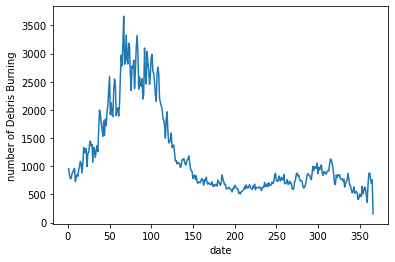

In [13]:
plt.xlabel('date')
plt.ylabel('number of Debris Burning')
plt.plot(indexedDataset)

In [14]:
#determing rolling statistics
rolmean=indexedDataset.rolling(window=24).mean()

rolstd=indexedDataset.rolling(window=24).std()
print(rolmean,rolstd)

STAT_CAUSE_DESCR  Debris Burning
DISCOVERY_DOY                   
1                            NaN
2                            NaN
3                            NaN
4                            NaN
5                            NaN
...                          ...
362                   565.875000
363                   570.916667
364                   575.458333
365                   585.125000
366                   568.750000

[366 rows x 1 columns] STAT_CAUSE_DESCR  Debris Burning
DISCOVERY_DOY                   
1                            NaN
2                            NaN
3                            NaN
4                            NaN
5                            NaN
...                          ...
362                   123.872063
363                   129.807522
364                   132.278027
365                   137.050074
366                   162.747671

[366 rows x 1 columns]


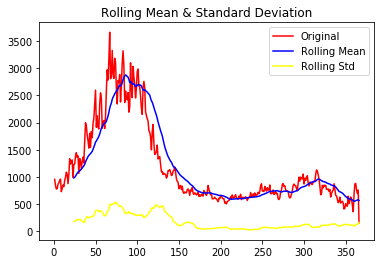

In [15]:
#Plot rolling statistics
orig=plt.plot(indexedDataset,color='red',label='Original')
mean=plt.plot(rolmean,color='blue',label='Rolling Mean')
std=plt.plot(rolstd,color='yellow',label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [16]:
from statsmodels.tsa.stattools import adfuller

In [17]:
#perform Dickey-Fuller test
print('Results of Dickey-Fuller Test:')
dftest=adfuller(indexedDataset['Debris Burning'],autolag='AIC')
dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#Lags Used','Number of Obercations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key]=value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                 -0.852671
p-value                         0.803159
#Lags Used                      6.000000
Number of Obercations Used    359.000000
Critical Value (1%)            -3.448697
Critical Value (5%)            -2.869625
Critical Value (10%)           -2.571077
dtype: float64


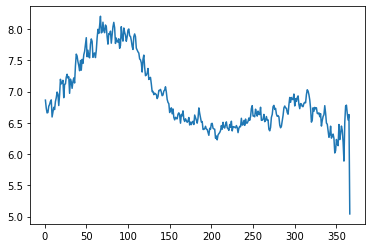

In [18]:
#estimating trend
indexedDataset_logScale=np.log(indexedDataset)
_=plt.plot(indexedDataset_logScale)

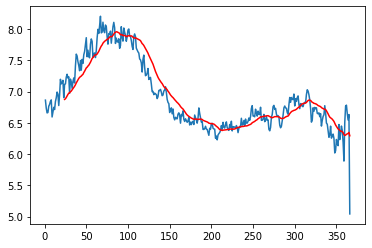

In [19]:
movingAverage=indexedDataset_logScale.rolling(window=24).mean()
movingSTD=indexedDataset_logScale.rolling(window=24).std()
_=plt.plot(indexedDataset_logScale)
_=plt.plot(movingAverage,color='red')

In [20]:
datasetLogScaleMinusMovingAverage=indexedDataset_logScale-movingAverage
datasetLogScaleMinusMovingAverage.head

<bound method NDFrame.head of STAT_CAUSE_DESCR  Debris Burning
DISCOVERY_DOY                   
1                            NaN
2                            NaN
3                            NaN
4                            NaN
5                            NaN
...                          ...
362                     0.466210
363                     0.324766
364                     0.214034
365                     0.286827
366                    -1.250448

[366 rows x 1 columns]>

In [21]:
#remove nan values
datasetLogScaleMinusMovingAverage.dropna(inplace=True)
datasetLogScaleMinusMovingAverage.head

<bound method NDFrame.head of STAT_CAUSE_DESCR  Debris Burning
DISCOVERY_DOY                   
24                      0.242134
25                      0.237001
26                      0.325469
27                      0.345620
28                      0.261431
...                          ...
362                     0.466210
363                     0.324766
364                     0.214034
365                     0.286827
366                    -1.250448

[343 rows x 1 columns]>

In [22]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    movingAverage=timeseries.rolling(window=12).mean()
    movingSTD=timeseries.rolling(window=12).std()
    
    orig=plt.plot(timeseries,color='green',label='Original')
    mean=plt.plot(movingAverage,color='red',label='Rolling Mean')
    std=plt.plot(movingSTD,color='black',label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    print('Results of Dickey-Fuller Test:')
    dftest=adfuller(timeseries['Debris Burning'],autolag='AIC')
    dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#Lags Used','Number of Obercations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key]=value
    print(dfoutput)

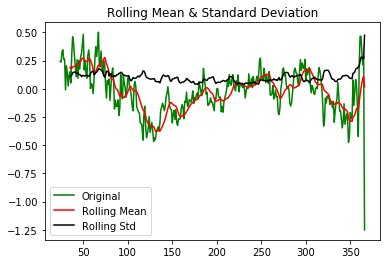

Results of Dickey-Fuller Test:
Test Statistic                 -2.333089
p-value                         0.161518
#Lags Used                     13.000000
Number of Obercations Used    329.000000
Critical Value (1%)            -3.450384
Critical Value (5%)            -2.870365
Critical Value (10%)           -2.571472
dtype: float64


In [23]:
test_stationarity(datasetLogScaleMinusMovingAverage)

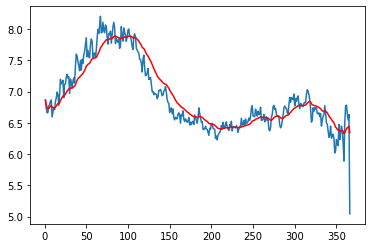

In [24]:
exponentialDecayWeightedAverage=indexedDataset_logScale.ewm(halflife=9,min_periods=0,adjust=True).mean()
plt.plot(indexedDataset_logScale)
_=plt.plot(exponentialDecayWeightedAverage,color='red')

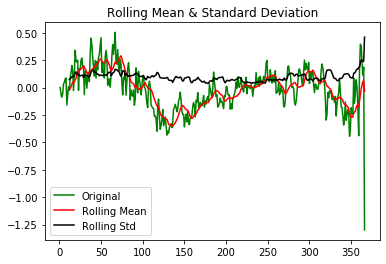

Results of Dickey-Fuller Test:
Test Statistic                 -2.226211
p-value                         0.196870
#Lags Used                      6.000000
Number of Obercations Used    359.000000
Critical Value (1%)            -3.448697
Critical Value (5%)            -2.869625
Critical Value (10%)           -2.571077
dtype: float64


In [25]:
datasetLogScaleMinusMovingExponentialDecayAverage=indexedDataset_logScale-exponentialDecayWeightedAverage
test_stationarity(datasetLogScaleMinusMovingExponentialDecayAverage)

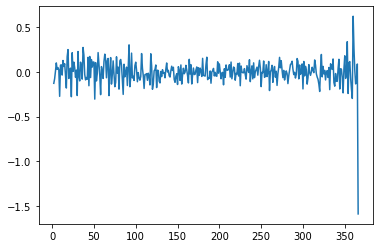

In [26]:
datasetLogDiffShifting=indexedDataset_logScale-indexedDataset_logScale.shift()
_=plt.plot(datasetLogDiffShifting)

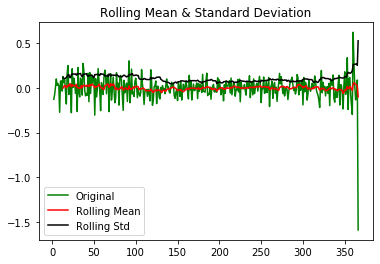

Results of Dickey-Fuller Test:
Test Statistic               -8.338740e+00
p-value                       3.218916e-13
#Lags Used                    6.000000e+00
Number of Obercations Used    3.580000e+02
Critical Value (1%)          -3.448749e+00
Critical Value (5%)          -2.869647e+00
Critical Value (10%)         -2.571089e+00
dtype: float64


In [27]:
datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting)

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [29]:
import statsmodels.api as sm

In [30]:
decomp = sm.tsa.seasonal_decompose(indexedDataset_logScale,freq=3)

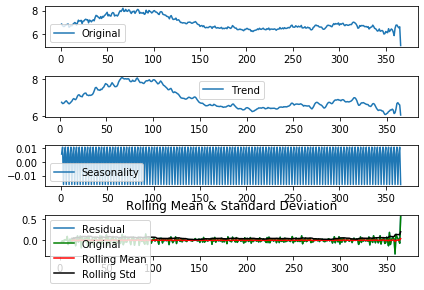

Results of Dickey-Fuller Test:
Test Statistic               -8.219212e+00
p-value                       6.498091e-13
#Lags Used                    1.700000e+01
Number of Obercations Used    3.460000e+02
Critical Value (1%)          -3.449392e+00
Critical Value (5%)          -2.869930e+00
Critical Value (10%)         -2.571240e+00
dtype: float64


In [31]:
trend=decomp.trend
seasonal=decomp.seasonal
residual=decomp.resid

plt.subplot(411)
plt.plot(indexedDataset_logScale,label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend,label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual,label='Residual')
plt.legend(loc='best')
plt.tight_layout()

decomposedLogData=residual
decomposedLogData.dropna(inplace=True)
test_stationarity(decomposedLogData)

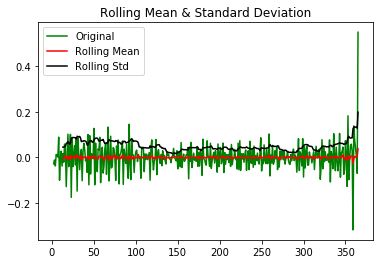

Results of Dickey-Fuller Test:
Test Statistic               -8.219212e+00
p-value                       6.498091e-13
#Lags Used                    1.700000e+01
Number of Obercations Used    3.460000e+02
Critical Value (1%)          -3.449392e+00
Critical Value (5%)          -2.869930e+00
Critical Value (10%)         -2.571240e+00
dtype: float64


In [32]:
decomposedLogData=residual
decomposedLogData.dropna(inplace=True)
test_stationarity(decomposedLogData)

In [33]:
from statsmodels.tsa.stattools import acf,pacf

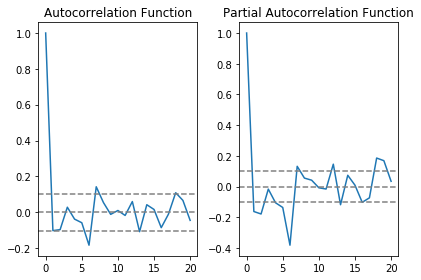

In [34]:
lag_acf=acf(datasetLogDiffShifting,nlags=20)
lag_pacf=pacf(datasetLogDiffShifting,nlags=20,method='ols')

plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

/Users/yt/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/yt/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Plotting AR model


/Users/yt/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


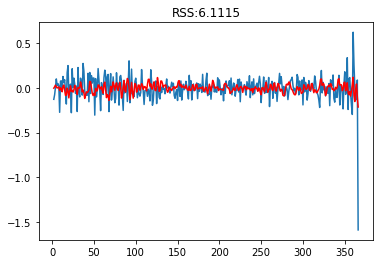

In [35]:
from statsmodels.tsa.arima_model import ARIMA

model=ARIMA(indexedDataset_logScale,order=(5,1,5))
results_AR=model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_AR.fittedvalues,color='red')
plt.title('RSS:%.4f'%sum((results_AR.fittedvalues-datasetLogDiffShifting['Debris Burning'])**2))
print('Plotting AR model')

/Users/yt/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/yt/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Text(0.5, 1.0, 'RSS: 5.7505')

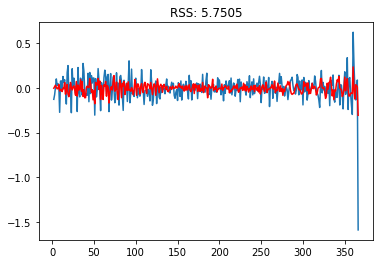

In [36]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(indexedDataset_logScale, order=(6, 1, 6))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(datasetLogDiffShifting)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-datasetLogDiffShifting['Debris Burning'])**2))


In [37]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

DISCOVERY_DOY
2   -0.003189
3    0.013784
4    0.029794
5    0.007729
6   -0.011049
dtype: float64


In [38]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum)

DISCOVERY_DOY
2     -0.003189
3      0.010595
4      0.040389
5      0.048118
6      0.037069
         ...   
362   -1.509476
363   -1.474100
364   -1.445675
365   -1.436332
366   -1.743209
Length: 365, dtype: float64


In [39]:
predictions_ARIMA_log= pd.Series(indexedDataset_logScale['Debris Burning'].iloc[0], index=indexedDataset_logScale.index)
predictions_ARIMA_log= predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0) 
predictions_ARIMA_log.head()

DISCOVERY_DOY
1    6.863803
2    6.860614
3    6.874398
4    6.904192
5    6.911921
dtype: float64

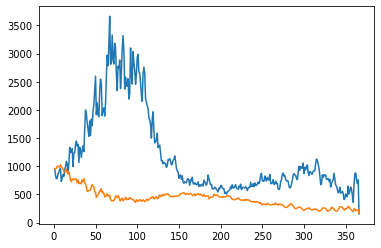

In [48]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(indexedDataset)
plt.plot(predictions_ARIMA)
#plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-indexedDataset['Debris Burning'])**2/len(indexedDataset))))


/Users/yt/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/yt/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/yt/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


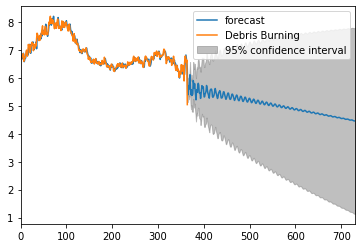

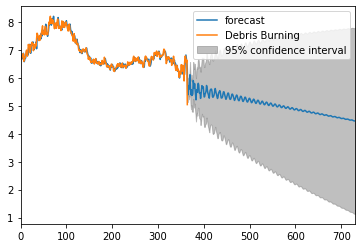

In [44]:
results_ARIMA.plot_predict(1,732)

In [49]:
results_ARIMA.forecast(steps=366)

(array([5.38647158, 5.69412653, 5.58031244, 5.72306808, 5.75743466,
        6.11143748, 5.53991853, 5.39936341, 5.57264711, 5.36932533,
        5.39570174, 5.41977636, 5.90775105, 5.79614385, 5.62896065,
        5.79536972, 5.59680301, 5.43010941, 5.21391653, 5.48088903,
        5.57479593, 5.48754518, 5.7562539 , 5.80668749, 5.74028954,
        5.46447549, 5.45105175, 5.46562932, 5.26555298, 5.40548603,
        5.58093407, 5.72177052, 5.65338494, 5.64098624, 5.68156109,
        5.42645777, 5.31587371, 5.33248789, 5.43250953, 5.46481586,
        5.52909473, 5.72809034, 5.66983682, 5.54637636, 5.45360988,
        5.40333451, 5.32864957, 5.27394319, 5.4471034 , 5.55585506,
        5.585139  , 5.6009365 , 5.5934915 , 5.50861001, 5.32716665,
        5.30317345, 5.3355216 , 5.36127822, 5.43661984, 5.5462821 ,
        5.6196999 , 5.53545699, 5.45883948, 5.40075938, 5.30984275,
        5.26284528, 5.30583158, 5.42794767, 5.48284755, 5.5149172 ,
        5.54262966, 5.48520708, 5.37508944, 5.28

In [ ]:
train = indexedDataset.value[:85]
test = indexedDataset.value[85:]

In [ ]:
model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(15, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()